## cross-validated kde log likelihoods
Here, you will test the "interchangeability" of rhythmic kde models fit to interneuron spike-phase distributions recorded when different odor-context combinations were being experienced. If a model is interchangeable, you'd expect a lot of overlap in log likelihoods when the model is predicting its training phase angles and unseen phase angles from other odor-context conditions. If the models are different, though, you'd expect differences between each cross-validated distribution of log likelihoods. 

In [10]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import kde_spikephase as kd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import statsmodels.formula.api as smf

from kde_spikephase import kde_spikephase_estimator_forarray
from joblib import dump, load
from mdl_eval_tools import bayes,kl,logloss
from pprint import pprint
from process_lfps import create_data_segments
from rayleigh_pr import rayleigh_pr
from scipy.signal import hilbert
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm

sns.set(font_scale=2,style='whitegrid')

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def get_neuron_cols(df,neuron_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes"""
    
    pattern = re.compile(neuron_expression)
    neuron_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            neuron_cols.append(matched.string)
    
    return neuron_cols

def get_allowable_lfp_wires(neuron_id,split_on):
    """neuron_id: string, e.g. TETSPK53b
    split_on: string, e.g. 'K', you will use this to exclude the unit letter from neuron_id"""

    #figure out who is the corresponding LFP for this neuron, must be on same tetrode!
    unit_wirenum = neuron.split(split_on)[1]
    unit_wirenum = unit_wirenum[:-1]
    if len(unit_wirenum) > 2:
        unit_wirenum = unit_wirenum[:2]
    allow_wire = [int(unit_wirenum), int(unit_wirenum) + 1, int(unit_wirenum) + 2, int(unit_wirenum) + 3]
    allow_wire = [str(w) for w in allow_wire]
    allow_wire = ['0'+w if int(w)<10 else w for w in allow_wire]
    
    return allow_wire

def get_lfp_cols(df,lfp_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes
    lfp_expression: string, e.g."""
#example lfp_expression =  "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        
    pattern = re.compile(lfp_expression)
    lfp_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            lfp_cols.append(matched.string)

    return lfp_cols


def example_cells_by_side_of_maze(cell_id,kde_odor,cluster_id_df,datapath,ymax,centered,savefig):
    
    example_cell_model = kde_odor[(kde_odor['cell_id'] == cell_id)]
    example_cell_clust = cluster_id_df[cluster_id_df['cell_id']==cell_id]
    
    file = cell_id.split('_')[0] + '_' + cell_id.split('_')[1] + '_correct.csv'
    example_cell_data = pd.read_csv(os.path.join(datapath,file))

    neuron = cell_id.split('_')[2]
    
    #find out which positions each odor in example_cell_clust occurs in
    condition_labels = list(set(example_cell_clust['condition_labels']))
    odor_side = []
    for condition in condition_labels: 

        which_pos = list(set(example_cell_data[example_cell_data['odor_labels']==condition]['pos_labels']))

        if which_pos == [1,2]: 

            side = 'left'

        elif which_pos == [3,4]: 

            side = 'right'

        dct = {'condition_labels': condition,
               'pos': which_pos,
               'side_of_maze': side
              }
        odor_side.append(pd.DataFrame(dct))

    odor_side_df = pd.concat(odor_side)
    
    example_cell_clust = example_cell_clust.merge(odor_side_df,on='condition_labels')
    
    rhythms = ['theta','beta','lowgamma','highgamma']

    sides = list(set(odor_side_df['side_of_maze']))

    fig,ax=plt.subplots(1,4,figsize=(20,5))

    counter = 0
    for side in sides: 

        if side == 'left':
            side_color = 'rosybrown'


        elif side == 'right': 
            side_color = 'steelblue'



        subside = example_cell_clust[example_cell_clust['side_of_maze']==side]

        conditions = list(set(subside['condition_labels']))

        for condition in conditions: 

            for rhythm in rhythms:

                subc = example_cell_model[(example_cell_model['condition_labels']==condition)&(example_cell_model['rhythm']==rhythm)]
                clust_data = subside[subside['condition_labels']==condition]
                inds = list(set(clust_data['spktrn_ind_labels']))

                if centered:
                    
                    if rhythm == 'theta':

                        varname = theta_kde_cent_odor

                    elif rhythm == 'beta':

                        varname = beta_kde_cent_odor

                    elif rhythm == 'lowgamma': 

                        varname = lowgamma_kde_cent_odor

                    elif rhythm == 'highgamma': 

                        varname = highgamma_kde_cent_odor
                        
                    if counter < 4:
                        ax[counter].plot(x,varname[inds,:].T,color=side_color,linewidth=6,alpha=0.7);
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter
                        
                else:
                    
                    if counter < 4:
                        ax[counter].plot(x,subc['kde_spikeprob'].values,color=side_color,linewidth=6,alpha=0.7);
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter
           

    if centered: 
        for a in ax:
            a.set_ylim(-ymax,ymax)
            
    else: 
        for a in ax:
            a.set_ylim(0,ymax)

    fig.tight_layout()
    
    if savefig: 
        
        fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_side_of_maze.pdf')



    return 



def example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,centered):
    
    example_cell_model = kde_odor[(kde_odor['cell_id'] == cell_id)]
    example_cell_clust = cluster_id_df[cluster_id_df['cell_id']==cell_id]

    file = cell_id.split('_')[0] + '_' + cell_id.split('_')[1] + '_correct.csv'
    example_cell_data = pd.read_csv(os.path.join(datapath,file))

    neuron = cell_id.split('_')[2]

    #find out which positions each odor in example_cell_clust occurs in
    condition_labels = list(set(example_cell_clust['condition_labels']))
    odor_side = []
    for condition in condition_labels: 

        which_pos = list(set(example_cell_data[example_cell_data['odor_labels']==condition]['pos_labels']))

        if which_pos == [1,2]: 

            side = 'left'

        elif which_pos == [3,4]: 

            side = 'right'

        dct = {'condition_labels': condition,
               'pos': which_pos,
               'side_of_maze': side
              }
        odor_side.append(pd.DataFrame(dct))

    odor_side_df = pd.concat(odor_side)

    example_cell_clust = example_cell_clust.merge(odor_side_df,on='condition_labels')

    rhythms = ['theta','beta','lowgamma','highgamma']

    sides = list(set(odor_side_df['side_of_maze']))

    fig,ax=plt.subplots(1,4,figsize=(20,5))

    counter = 0
    for side in sides: 

        if side == 'left':
            side_colors = ['red','rosybrown','firebrick','lightcoral']


        elif side == 'right': 
            side_colors = ['steelblue','dodgerblue','lightskyblue','powderblue']


        subside = example_cell_clust[example_cell_clust['side_of_maze']==side]

        conditions = list(set(subside['condition_labels']))

        for cind,condition in enumerate(conditions): 

            for rhythm in rhythms:

                subc = example_cell_model[(example_cell_model['condition_labels']==condition)&(example_cell_model['rhythm']==rhythm)]
                clust_data = subside[subside['condition_labels']==condition]
                inds = list(set(clust_data['spktrn_ind_labels']))

                if centered:

                    if rhythm == 'theta':

                        varname = theta_kde_cent_odor

                    elif rhythm == 'beta':

                        varname = beta_kde_cent_odor

                    elif rhythm == 'lowgamma': 

                        varname = lowgamma_kde_cent_odor

                    elif rhythm == 'highgamma': 

                        varname = highgamma_kde_cent_odor

                    if counter < 4:

                        if cind >= 4: 

                            cind = cind - 4

                        ax[counter].plot(x,varname[inds,:].T,color=side_colors[cind],linewidth=6,alpha=0.7,label=str(condition));
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter


                else:

                    if counter < 4:

                        if cind >= 4: 

                            cind = cind - 4

                        ax[counter].plot(x,subc['kde_spikeprob'].values,color=side_colors[cind],linewidth=6,alpha=0.7,label=str(condition));
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter


    if centered: 
        for a in ax:
            a.set_ylim(-ymax,ymax)
            

    else: 
        for a in ax:
            a.set_ylim(0,ymax)
            
    fig.legend()
    fig.tight_layout()
    

    return fig





### fit and save kde model objects

In [12]:
#fitting params
n_splits = 7
grid_size = 1000
bw_narrow = 1/30
bw_wide = 1/.6
n_bw = 20
rhythms = ['theta','lowgamma','highgamma']


datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)


savepath = 'kde_model_objects_ints/'
for file in tqdm(files, position=0, desc="file", leave=True, colour='dodgerblue'): 

    kde_df = [] #initialize the df that will contain all of this file's data

    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']

    df = [] #clear out to save memory

    quarters = list(set(odorsamp_df['quarter_labels']))

    for quarter in tqdm(quarters,position=1,desc='quarter',leave=False,colour='lavender'): 

        subq = odorsamp_df[odorsamp_df['quarter_labels']==quarter]

        if np.all(subq['accuracy'] >= .75):

            neuron_cols = get_neuron_cols(subq,'TETSPK')

            for rhythm in tqdm(rhythms,position=2,desc='rhythm',leave=False,colour='hotpink'): 

                for neuron in tqdm(neuron_cols,position=3,desc='neuron',leave=False,colour='mediumturquoise'): 

                    cell_id = file.split('_')[0] + '_' + file.split('_')[1] + '_' + neuron

                    allow_wire = get_allowable_lfp_wires(neuron,'K')

                    #grab the lfps
                    lfp_cols = get_lfp_cols(subq,"TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z")
                    lfp_name = lfp_cols[0]

                    #create the phase columns using the hilbert transform on the filtered lfp
                    filt_name = lfp_name + 'filt_' + rhythm 

                    filtered = subq[filt_name]
                    analytic_signal = hilbert(filtered)

                    phase_name = lfp_name + 'phase_' + rhythm 
                    subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);

                    #get the unique odor position identifiers for each condition
                    condition_labels = subq.groupby(['odor_labels']).sum().index

                    for condition in condition_labels:

                        #need to filter the dataset by condition now
                        odor = condition

                        d = subq[(subq['odor_labels']==odor)]

                        ntrials = len(set(d['trial_labels']))

                        if ntrials >= 4: 

                            #now, grab the spikes and phases to fit the kde curves
                            #grab data
                            spikes = d[neuron].values
                            phases = d[phase_name].values

                            phi_when_sp = []
                            for s,p in zip(spikes,phases):
                                if s==1: 
                                    phi_when_sp.append(p)

                            phi_when_sp = np.array(phi_when_sp)

                            #CRITERION: number of spikes must exceed the number of cross val splits for fitting kde
                            if n_splits < sum(spikes):

                                kde_phaseprob, kde, bw = kde_spikephase_estimator_forarray(phi_when_sp,n_splits,grid_size,bw_narrow,bw_wide,n_bw)

                                spike_prior = d[neuron].sum()/d.shape[0]
                                phase_prior = 1/(2*np.pi)
                                kde_spikeprob = bayes(kde_phaseprob,
                                                        spike_prior,
                                                        phase_prior
                                  )

            #                     ax.plot(np.linspace(-np.pi,np.pi,grid_size), pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % bw)

#                                 pickled_kde = pickle.dumps(kde)
                                model_name = 'kde_'+ cell_id + '_' + str(odor) + '_' + rhythm +'.joblib'
                                dump(kde,model_name)

                                dct = {'cell_id': cell_id,
                                       'quarter_labels': np.repeat(quarter,len(phi_when_sp)),
                                       'rhythm': np.repeat(rhythm,len(phi_when_sp)),
                                       'kde_model_object': model_name,
                                       'bw': np.repeat(bw,len(phi_when_sp)),
                                       'phi_when_sp': phi_when_sp,
                                       'condition_labels': np.repeat(odor,len(phi_when_sp))
                                        }
                                kde_df.append(pd.DataFrame(dct))

    kde_odor = pd.concat(kde_df)  


    if not os.path.exists(savepath): 
        os.makedirs(savepath)

    savename = file.split('_')[0] + '_' + file.split('_')[1] + '_kde_models.csv'
    kde_odor.to_csv(os.path.join(savepath,savename),index=False)





file:   0%|          | 0/18 [00:00<?, ?it/s]

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2622732407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


#### load the fit kde model objects

In [13]:
datapath = 'kde_model_objects_ints/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]

In [14]:
all_used_inds = []
results_test = []

rhythms = ['theta','lowgamma','highgamma']

n_cv_folds = 5
for file in tqdm(files,position=0,colour='cornflowerblue'): 
    
    
    kde_odor = pd.read_csv(os.path.join(datapath,file))
    
    cell_labels = list(set(kde_odor['cell_id']))

    
    condition_labels = list(set(kde_odor['condition_labels']))

    
    for cell_id in cell_labels: 

        subcell = kde_odor[kde_odor['cell_id']==cell_id]

        for rhythm in tqdm(rhythms,position=1,colour='hotpink',leave=False): 

            for condition in condition_labels:

                subcond = subcell[(subcell['condition_labels']==condition) & (subcell['rhythm']==rhythm)]

                model = load(subcond.iloc[0]['kde_model_object'])
                angles = subcond['phi_when_sp'].values

                #partition angles into equally-sized folds 
                n_angles_fold = int(len(angles)/n_cv_folds)
                all_inds = range(len(angles))

                for k in range(n_cv_folds):

                    if k == 0:
                        fold_inds = random.sample(all_inds,n_angles_fold)

                        all_used_inds = np.array(fold_inds)
                        remaining_inds = [i for i in all_inds if i not in fold_inds]

                    else: 

                        fold_inds = random.sample(remaining_inds,n_angles_fold)

                        all_used_inds = np.hstack((all_used_inds, fold_inds))
                        remaining_inds = [i for i in all_inds if i not in all_used_inds]

                     
                    #compute the mean log likelihood
                    fold_angles = angles[fold_inds]
                    compare_self = np.mean(model.score_samples(fold_angles.reshape(-1,1)))

                    results_test.append({'cell_id': cell_id,
                                         'mean_loglik': compare_self,
                                         'train_condition': condition,
                                         'test_condition': condition,
                                         'test_type': 'self',
                                         'rhythm': rhythm,
                                         'cv_fold': k
                                        })


                ## Go through the others
                for c2 in condition_labels:

                    if c2 == condition:
                        continue


                    subcond = subcell[(subcell['condition_labels']==c2) & (subcell['rhythm']==rhythm)]
                    angles = subcond['phi_when_sp'].values
                    comparison = model.score_samples(angles.reshape(-1,1))

                    #partition angles into equally-sized folds 
                    n_angles_fold = int(len(angles)/n_cv_folds)
                    all_inds = range(len(angles))

                    for k in range(n_cv_folds):
                
                        if k == 0:
                            fold_inds = random.sample(all_inds,n_angles_fold)

                            all_used_inds = np.array(fold_inds)
                            remaining_inds = [i for i in all_inds if i not in fold_inds]


                        else: 

                            fold_inds = random.sample(remaining_inds,n_angles_fold)

                            all_used_inds = np.hstack((all_used_inds, fold_inds))
                            remaining_inds = [i for i in all_inds if i not in all_used_inds]

                        #compute the mean log likelihood
                        fold_angles = angles[fold_inds]
                        comparison = np.mean(model.score_samples(fold_angles.reshape(-1,1)))

                        results_test.append({'cell_id': cell_id,
                                             'mean_loglik': comparison,
                                             'train_condition': condition,
                                             'test_condition': c2,
                                             'test_type': 'other',
                                             'rhythm': rhythm,
                                             'cv_fold': k
                                            })

loglik_df = pd.DataFrame(results_test)





  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

#### mean log likelihoods per cross validation fold, per rhythm

In [15]:
mean_loglik_df = loglik_df.groupby(['cell_id','rhythm','test_type','cv_fold']).mean()['mean_loglik'].reset_index()

Fit the following linear mixed effects model, where test type (self/own, other) and rhythm (theta, low gamma, high gamma) are fixed effects, and we account for individual neuron-by-neuron variation by setting random intercepts for cell identity. 

In [16]:
md = smf.mixedlm("mean_loglik ~ test_type + rhythm", data=mean_loglik_df, groups=mean_loglik_df["cell_id"])

mdf = md.fit()

print(mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   mean_loglik
No. Observations:   900       Method:               REML       
No. Groups:         30        Scale:                0.0013     
Min. group size:    30        Log-Likelihood:       1656.3047  
Max. group size:    30        Converged:            Yes        
Mean group size:    30.0                                       
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          -2.932    0.004 -771.644 0.000 -2.939 -2.924
test_type[T.self]   0.034    0.002   13.932 0.000  0.029  0.039
rhythm[T.lowgamma] -0.005    0.003   -1.780 0.075 -0.011  0.001
rhythm[T.theta]     0.030    0.003   10.194 0.000  0.025  0.036
Group Var           0.000    0.002                             



/Users/pamelariviere/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
mean_loglik_df.groupby(["test_type","rhythm"]).mean()

cv_fold  mean_loglik
test_type rhythm                         
other     highgamma      2.0    -2.927066
          lowgamma       2.0    -2.940666
          theta          2.0    -2.902665
self      highgamma      2.0    -2.902690
          lowgamma       2.0    -2.899691
          theta          2.0    -2.866364

In [18]:
mean_loglik_df.groupby(["test_type"]).mean()

,cv_fold,mean_loglik
test_type,,
other,2.0,-2.923465
self,2.0,-2.889582


### Figure 4G

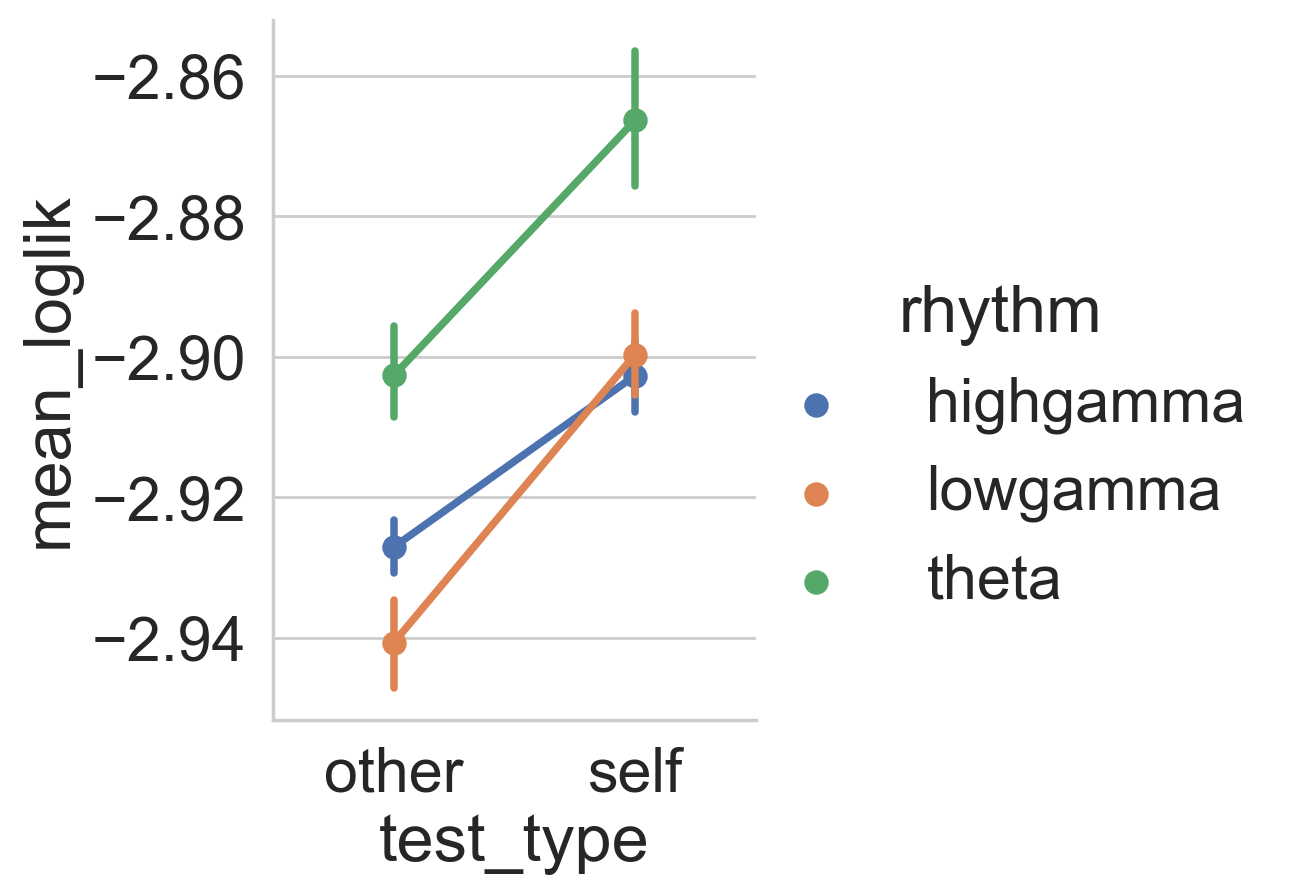

In [21]:

sns.catplot(data = mean_loglik_df, x = "test_type", y = "mean_loglik",
          kind = "point", hue = "rhythm")

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
plt.savefig(os.path.join(figpath,'crossval_mean_loglik_testtype_rhythm.pdf'))

### Figure 4B (top row, right subpanel)


/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/727413697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['same'] = df_results['train_condition'] == df_results['test_condition']


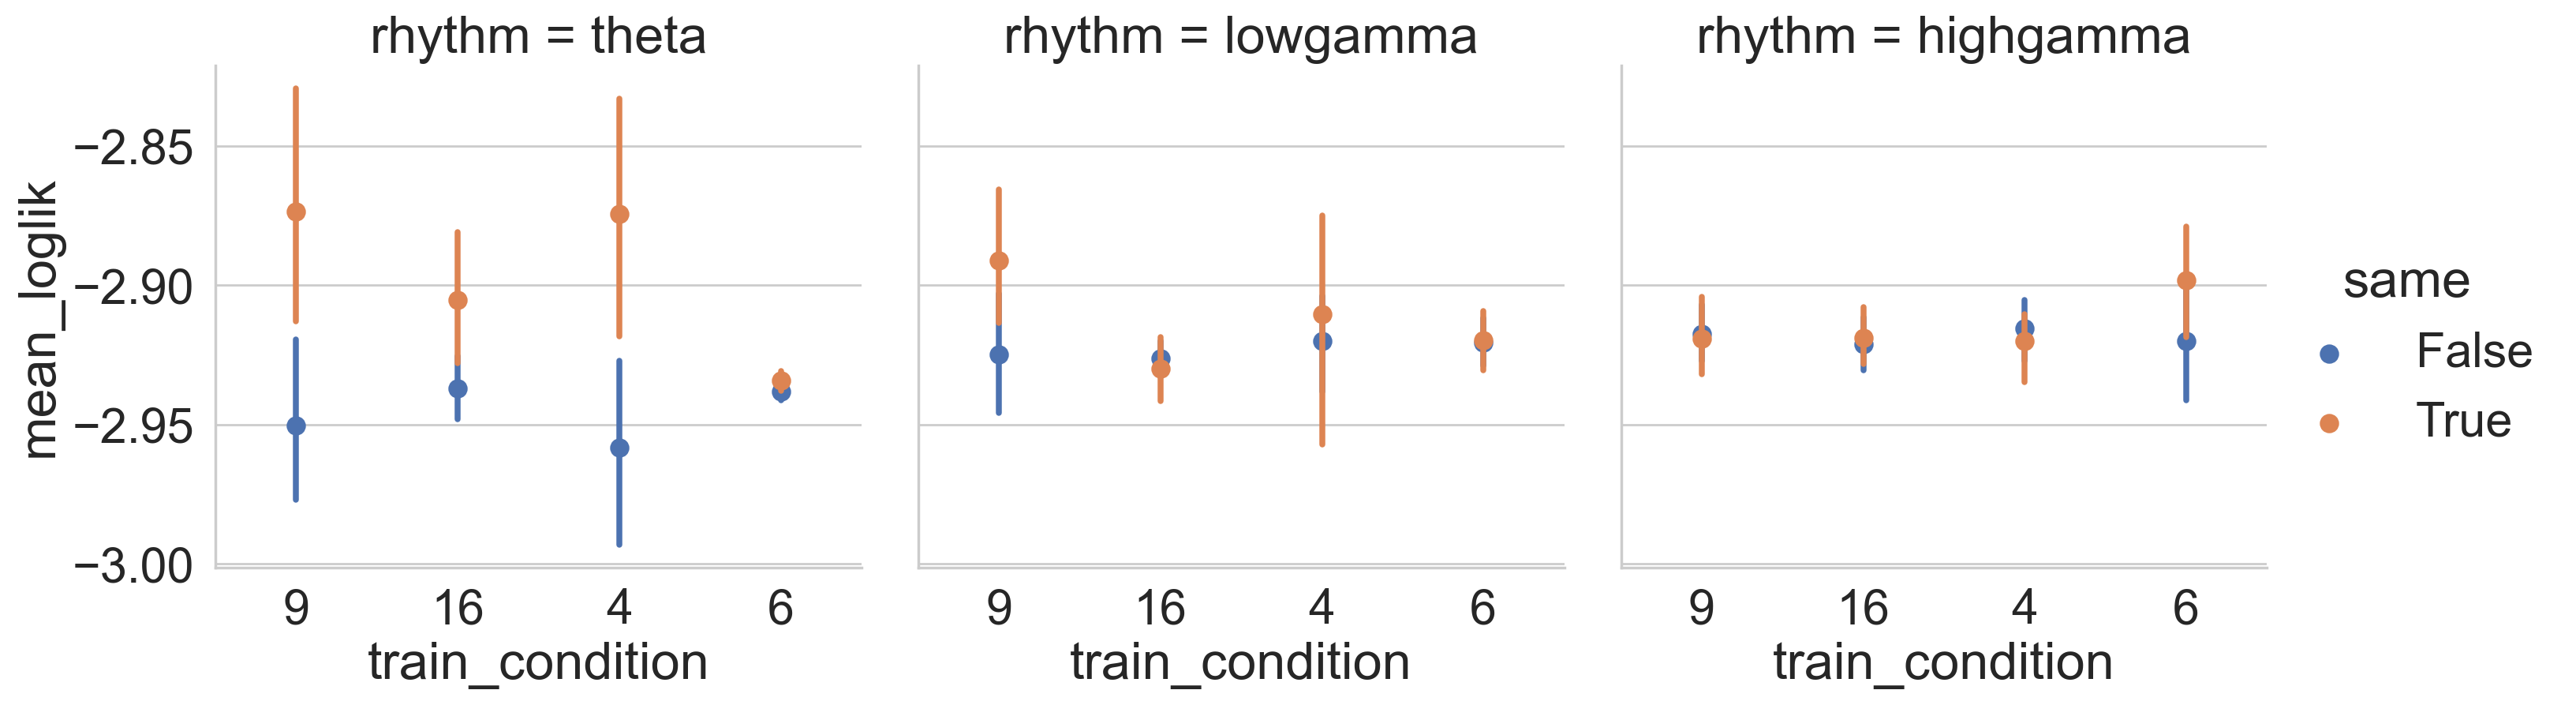

In [22]:
cell_id = 'LH02_D14_TETSPK13b'
df_results = loglik_df[loglik_df['cell_id']==cell_id]

df_results['same'] = df_results['train_condition'] == df_results['test_condition']

category_order = [9,16,4,6]
sns.catplot(data = df_results, x = "train_condition", hue = "same", y = "mean_loglik", kind = "point", 
            join = False, col = "rhythm",order=category_order)


figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
plt.savefig(os.path.join(figpath,'example_cell_'+cell_id+'_'+'crossval_mean_loglik_self_v_other.pdf'))

### Figure 4B (bottom row, right subpanel)

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/1462757777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['same'] = df_results['train_condition'] == df_results['test_condition']


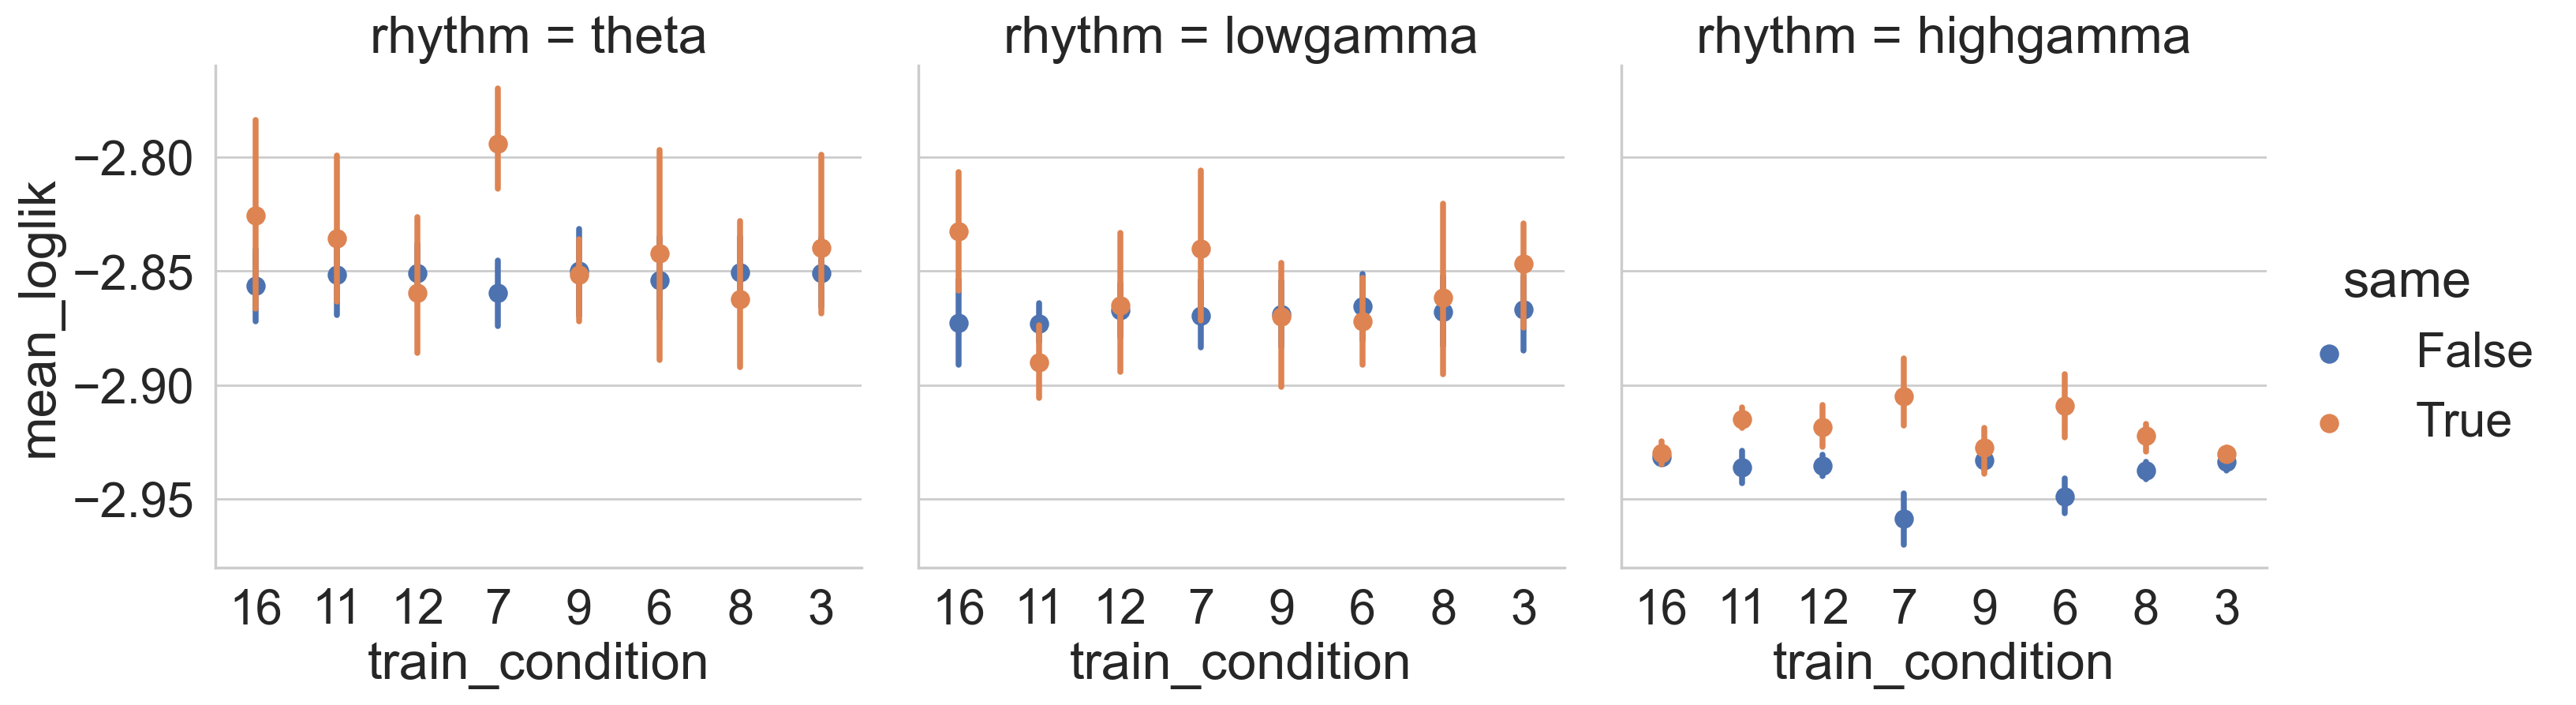

In [23]:
cell_id = 'LH16_D29_TETSPK09a'
df_results = loglik_df[loglik_df['cell_id']==cell_id]

df_results['same'] = df_results['train_condition'] == df_results['test_condition']

category_order = [16,11,12,7,9,6,8,3]
sns.catplot(data = df_results, x = "train_condition", hue = "same", y = "mean_loglik", kind = "point", 
            join = False, col = "rhythm",order=category_order)

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
plt.savefig(os.path.join(figpath,'example_cell_'+cell_id+'_'+'crossval_mean_loglik_self_v_other.pdf'))

### Figure 4D (right subpanel)

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2400699908.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['same'] = df_results['train_condition'] == df_results['test_condition']


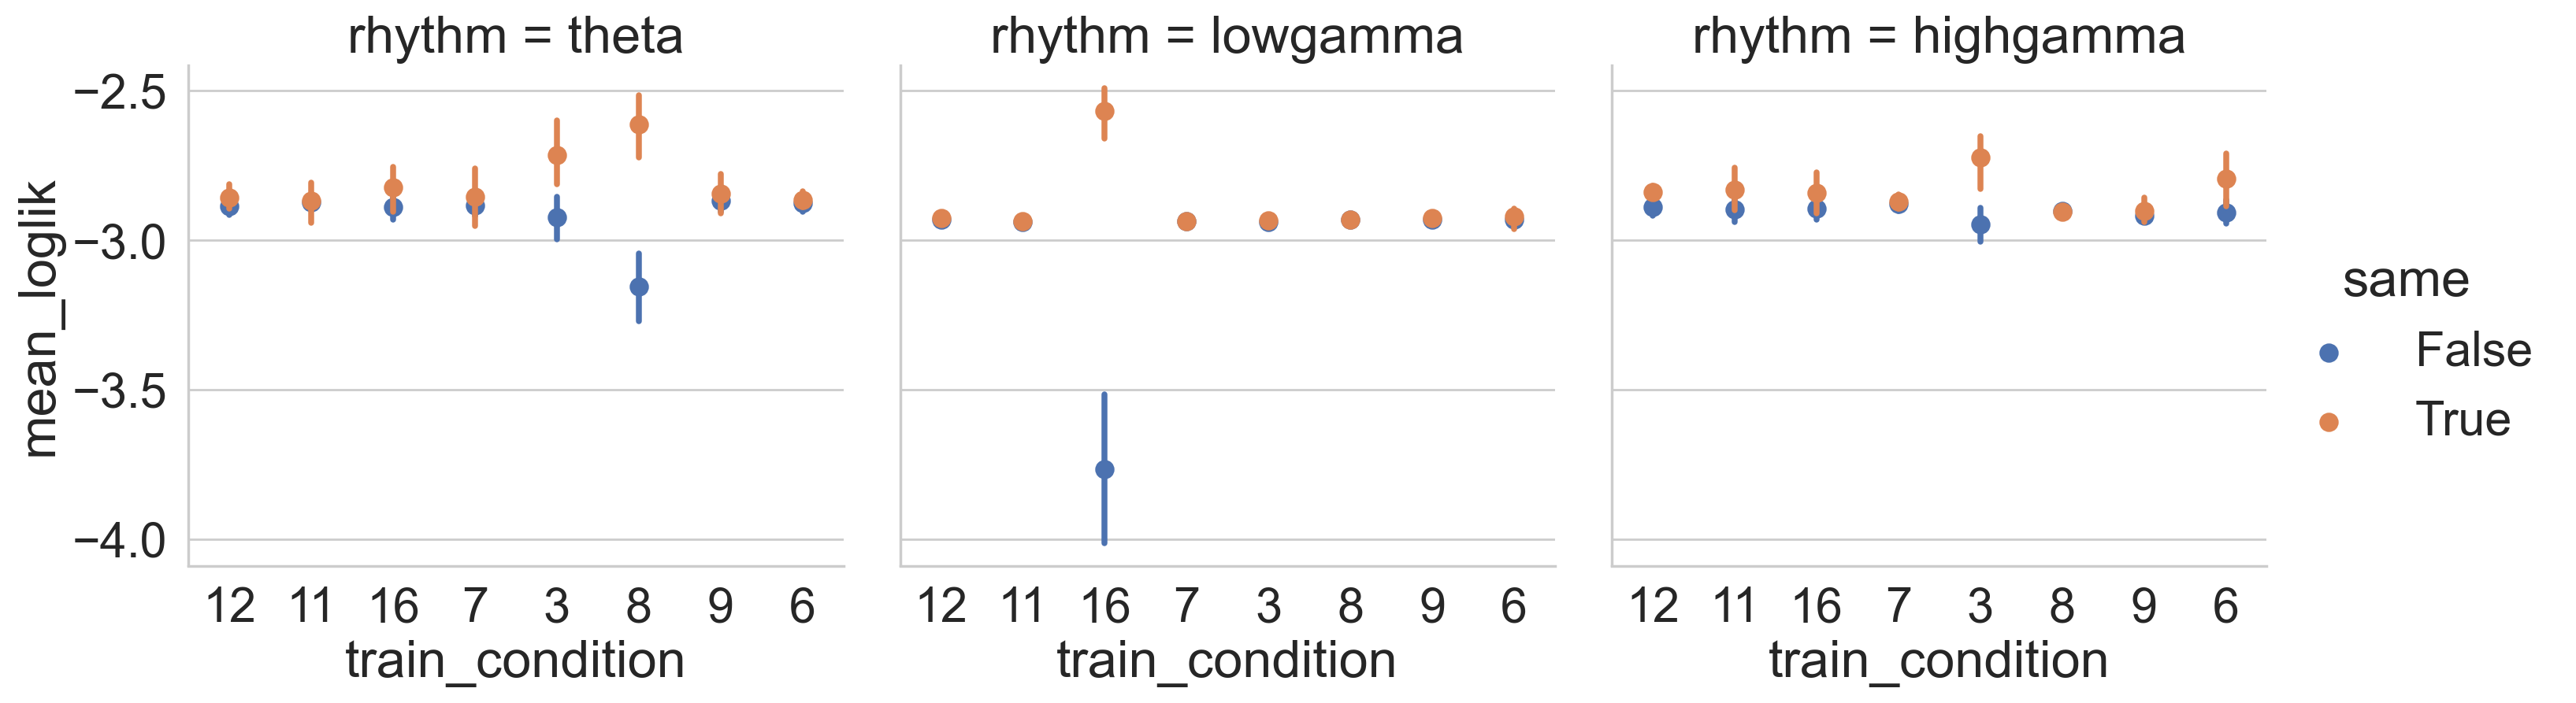

In [24]:
cell_id = 'LH16_D25_TETSPK33m'
df_results = loglik_df[loglik_df['cell_id']==cell_id]

df_results['same'] = df_results['train_condition'] == df_results['test_condition']

category_order = [12,11,16,7,3,8,9,6]
sns.catplot(data = df_results, x = "train_condition", hue = "same", y = "mean_loglik", kind = "point", 
            join = False, col = "rhythm",order=category_order)

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
plt.savefig(os.path.join(figpath,'example_cell_'+cell_id+'_'+'crossval_mean_loglik_self_v_other.pdf'))

### Figure 4F (right subpanel)

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2806/2271383582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['same'] = df_results['train_condition'] == df_results['test_condition']


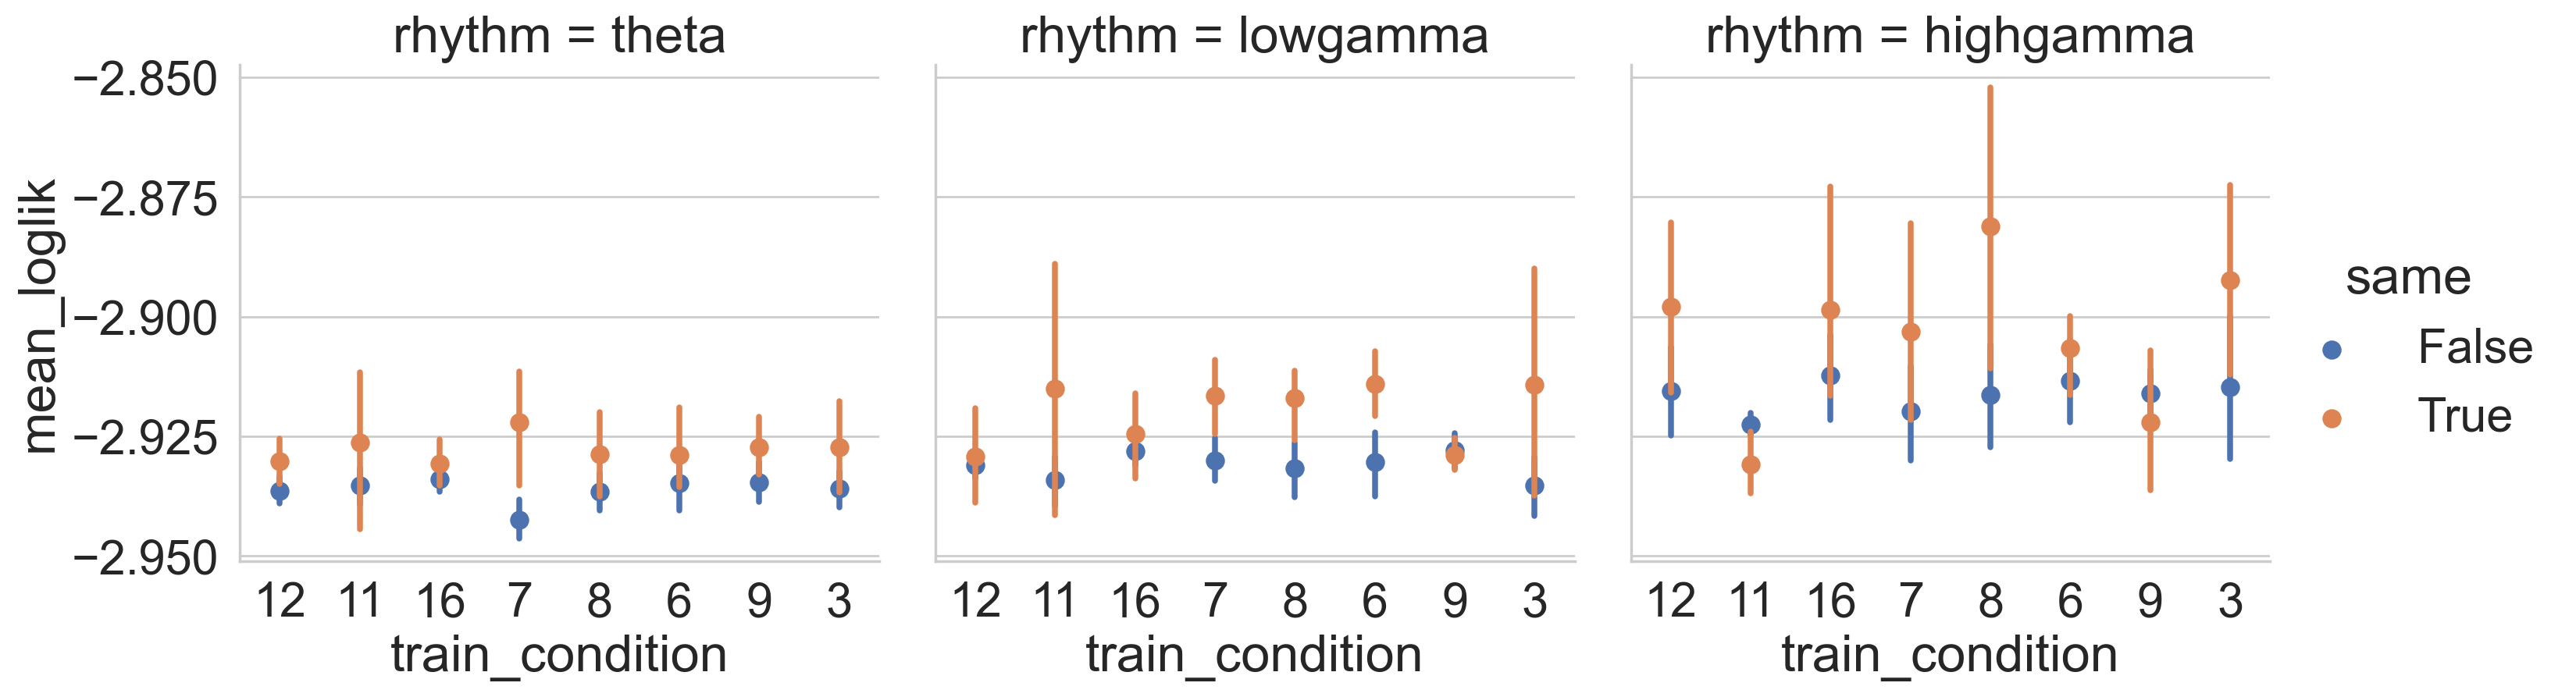

In [25]:
cell_id = 'LH08_D32_TETSPK09c'
df_results = loglik_df[loglik_df['cell_id']==cell_id]

df_results['same'] = df_results['train_condition'] == df_results['test_condition']

category_order = [12,11,16,7,8,6,9,3]
sns.catplot(data = df_results, x = "train_condition", hue = "same", y = "mean_loglik", kind = "point", 
            join = False, col = "rhythm",order=category_order)

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
plt.savefig(os.path.join(figpath,'example_cell_'+cell_id+'_'+'crossval_mean_loglik_self_v_other.pdf'))

### set up the dataset for the log likelihood ratio, to be performed in R

In [26]:
mean_loglik_df = loglik_df.groupby(['cell_id','rhythm','test_type']).mean()['mean_loglik'].reset_index()
mean_loglik_df = mean_loglik_df[mean_loglik_df['rhythm'].isin(['theta','lowgamma','highgamma'])]

mean_loglik_df.to_csv('crossval_mean_loglik_df.csv')